In [19]:
import pandas as pd

sun_df = pd.read_csv('hg38_features_ab_merge.txt', sep='\t')
sun_df.columns = ['loc', 'NAB', 'NC', 'ND', 'NN']
sun_df = (sun_df.set_index('loc') * 2).reset_index()
sun_df.head()

,loc,NAB,NC,ND,NN
0,1799,0,0,0,2
1,1921,0,0,2,0
2,1983,0,0,0,2
3,2129,4,0,0,0
4,2136,2,0,0,0


In [20]:
from glob import glob

In [21]:
from tools.bio import *
fa = '/hive/users/cbosworth/refs/notch/notch2_aligned_consensus.fasta'
_, seq = read_fasta(fa, None).next()

In [4]:
def ref_count(s):
    return s[s.ref]


def load_pileup(pileup_path):
    r = [x.split() for x in open(pileup_path)]
    return pd.DataFrame(r[1:], columns=r[0])



def convert_pileup(pileup_recs, pileup_converter):
    with TemporaryFilePath() as tmp, TemporaryFilePath() as tmp2:
        with open(tmp, 'w') as outf:
            for l in pileup_recs:
                outf.write(l + '\n')
        cmd = ['perl', pileup_converter, tmp, 0, tmp2]
        r = run_proc(cmd, stderr='/dev/null', stdout='/dev/null')
        return load_pileup(tmp2)

    
def make_pileup(bam):
    """Construct a pileup from a bam"""
    cmd = ['samtools', 'mpileup', bam]
    return call_proc_lines(cmd)


bases = {'A', 'T', 'G', 'C'}
def alt_count(s):
    return sum(s[x] for x in bases if x != s.ref)


def parse_converted_pileup(df, seq):
    df['loc'] = np.array(map(int, df['loc'])) - 1
    df['ref'] = [seq[i] for i in df['loc']]
    df = df[df.ref.isin(bases)]
    df['A'] = pd.to_numeric(df['A']) + pd.to_numeric(df['a'])
    df['C'] = pd.to_numeric(df['C']) + pd.to_numeric(df['c'])
    df['G'] = pd.to_numeric(df['G']) + pd.to_numeric(df['g'])
    df['T'] = pd.to_numeric(df['T']) + pd.to_numeric(df['t'])
    df = df[['loc', 'ref', 'A', 'C', 'G', 'T']]
    df['coverage'] = df[['A', 'T', 'G', 'C']].sum(axis=1)
    df['ref_count'] = df.apply(ref_count, axis=1)
    df['alt_count'] = df.apply(alt_count, axis=1)
    df['ratio'] = 1.0 * df.alt_count / (df.alt_count + df.ref_count)
    return df


In [5]:
import numpy as np
from tools.procOps import *
from tools.fileOps import *
import multiprocessing
bases = {'A', 'T', 'G', 'C'}
pileup_converter = '/cluster/home/ifiddes/pileup2base/pileup2base.pl'
pd.set_option('chained_assignment',None)
def parse_fn(bam):
    n = os.path.basename(bam).split('.')[0]
    pileup_recs = make_pileup(bam)
    df = convert_pileup(pileup_recs, pileup_converter)
    df = parse_converted_pileup(df, seq)
    out = os.path.join('/hive/users/ifiddes/simons_normals', n + '.parsed_pileup.txt')
    df.to_csv(out, sep='\t')
    return df


bams = glob('/hive/users/ifiddes/simons_normals/*.filtered.consensus.bam')
p = multiprocessing.Pool(processes=10)
r = p.map(parse_fn, bams)
dfs = {os.path.basename(bam).split('.')[0]: df for bam, df in zip(bams, r)}
p.close()
p.join()

In [23]:
# now try this on real data

# load parsed pileups
files = glob('/hive/users/ifiddes/simons_normals/*.parsed_pileup.txt')
dfs = {}
for f in files:
    n = os.path.basename(f).split('.')[0]
    dfs[n] = pd.read_csv(f, sep='\t', index_col=0)
    
# load C/D copy number estimates

files = glob('/hive/users/ifiddes/simons_normals/*.filtered.txt')
def convert(x):
    x = x.split(':')
    n, v = x
    v = int(v)
    return n, v

copy_number = {}
for x in files:
    n = os.path.basename(x).split('.')[0]
    l = open(x).next().rstrip().split()
    c = []
    for x in l[2:4]:
        _, v = convert(x)
        c.append(v)
    copy_number[n] = c
    
    
# filter dataframes for C = 2 and D = 2
# also filter for informative positions
filtered_dfs = {}
for n, df in dfs.iteritems():
    c = copy_number[n]
    if sum(c) != 4:
        continue
    df_m = df.merge(sun_df, on='loc')
    df_m = df_m[df_m['loc'].isin(sun_df['loc'])]
    filtered_dfs[n] = df_m

In [26]:
def calculate_deviance(s):
    if s.alt_count == 0 or s.coverage <= 20:
        return None
    deviance = (s.expected_alt - s.alt_count) / (np.sqrt(1.0 * s.coverage * s.ratio * (1 - s.ratio)))
    return deviance


def calculate_expected(s, tot):
    """Expected value"""
    expected_ratio = (1.0 * s.NAB + s.NC + s.ND + s.NN) / tot
    return expected_ratio * s.coverage

In [27]:
positions = set(sun_df['loc'])
dev_dfs = {}
for n, df in dfs.iteritems():
    if n not in m:
        continue
    num_c, num_d = m[n]
    tot = 6 + num_c + num_d
    df_m = df.merge(sun_df, on='loc')
    df_m['NC'] = [x - (2 - num_c) if x != 0 else x for x in df_m['NC']]
    df_m['ND'] = [x - (2 - num_d) if x != 0 else x for x in df_m['ND']]
    df_m['expected_alt'] = df_m.apply(calculate_expected, axis=1, tot=tot)
    df_m['deviance'] = df_m.apply(calculate_deviance, axis=1)
    dev_dfs[n] = df_m

In [28]:
from collections import *
deviances = defaultdict(list)
for n, df in dev_dfs.iteritems():
    for p, d in zip(df['loc'], df['deviance']):
        deviances[p].append(d)

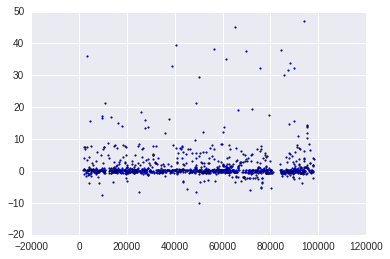

In [29]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
vals = sorted(deviances.iteritems(), key=lambda x: x[0])
positions, vals = zip(*vals)
vals = [np.nanmean(x) for x in vals]
plt.scatter(positions, vals, s=3)

In [30]:
from collections import *

deviances_by_paralog = defaultdict(lambda: defaultdict(list))

for n, df in dev_dfs.iteritems():
    for _, s in df.iterrows():
        if s.NN > 0:
            deviances_by_paralog['NN'][s['loc']].append(s['deviance'])
        if s.NA > 0:
            deviances_by_paralog['NA'][s['loc']].append(s['deviance'])
        if s.NB > 0:
            deviances_by_paralog['NB'][s['loc']].append(s['deviance'])
        if s.NC > 0:
            deviances_by_paralog['NC'][s['loc']].append(s['deviance'])
        if s.ND > 0:
            deviances_by_paralog['ND'][s['loc']].append(s['deviance'])

AttributeError: 'Series' object has no attribute 'NA'

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2)
for ax, p in zip(axes.flat, deviances_by_paralog):
    vals = sorted(deviances_by_paralog[p].iteritems(), key=lambda x: x[0])
    positions, vals = zip(*vals)
    vals = [np.nanmean(x) for x in vals]
    ax.scatter(positions, vals, s=3)
    ax.set_title(p)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
import matplotlib.mlab as mlab
import math
mu = 0
variance = 1
sigma = math.sqrt(variance)
norm_x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

for ax, p in zip(axes.flat, deviances_by_paralog):
    v = deviances_by_paralog[p].values()
    v = [x for x in v if len(x) > 50]
    s = random.sample(v, 20)
    for d in s:
        tmp = [value for value in d if not math.isnan(value)]
        tmp = [x for x in tmp if -5 < x <= 20]
        if len(tmp) > 20:
            g = sns.distplot(tmp, kde=False, bins=25, ax=ax, norm_hist=True)
            g.set_title(p)
    ax.plot(norm_x, mlab.normpdf(norm_x, mu, sigma), color='black')

In [ ]:
# distribution of average deviances for each
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)
for ax, p in zip(axes.flat, deviances_by_paralog):
    v = deviances_by_paralog[p].values()
    v = [np.nanmean(x) for x in v if len(x) > 25]
    v = [x for x in v if -5 < x <= 5]
    g = sns.distplot(v, bins=20, ax=ax)
    g.set_title(p)
    g.set_xlim(-5, 5)

In [31]:
bad_positions = {x for x, y in deviances.iteritems() if np.nanmean(y) > 3 or np.nanmean(y) < -3}

print bad_positions

set([22019, 80389, 54799, 88082, 77847, 16413, 69153, 25125, 8113, 85546, 18988, 19503, 65587, 75829, 28726, 48696, 12277, 2621, 14398, 90549, 40517, 2129, 68695, 2136, 62558, 66149, 16993, 43621, 55398, 4202, 60434, 13422, 56509, 96371, 4212, 74357, 86646, 76407, 44664, 30843, 35946, 42113, 39042, 80009, 10892, 4710, 63128, 67739, 30876, 24733, 19474, 91643, 91296, 47265, 23202, 30887, 18088, 52907, 78512, 10417, 58035, 89780, 89782, 48823, 43197, 48928, 31939, 72392, 72394, 32973, 93902, 50389, 45282, 76923, 56558, 65776, 67831, 69880, 91899, 71941, 3337, 9996, 87682, 75535, 62738, 56195, 46356, 25881, 9519, 50461, 15134, 90912, 71472, 26402, 31012, 15656, 24876, 69934, 31023, 98096, 3378, 90420, 76603, 56636, 12260, 87605, 70465, 59716, 76101, 60230, 71782, 84299, 88175, 78162, 61267, 76116, 42837, 9700, 10586, 65373, 76126, 7010, 59236, 14182, 37735, 4978, 50040, 18340, 26497, 76163, 97668, 91969, 9099, 9614, 40341, 94191, 7584, 19952, 69539, 70052, 96173, 87197, 42929, 51637, 3883

In [32]:
len(sun_df)

1069

In [34]:
len(bad_positions)

186